# Setup

In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: ROICaT
python version: 3.9.13


In [2]:
import os, sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import natsort

import torch

import gc
import time
import functools
import multiprocessing as mp
import scipy.io


In [3]:
tic = time.time()
toc = {}
toc['start'] = time.time() - tic

In [4]:
%load_ext autoreload
%autoreload 2

dir_github = os.path.join('C:','\\Users','andrew','Documents','gitRepositories')
sys.path.append(dir_github)

import roicat
from roicat import helpers, data_importing, ROInet
from roicat.tracking import alignment, blurring, clustering, scatteringWaveletTransformer, similarity_graph, visualization

In [5]:
%matplotlib notebook

# Import paths

In [6]:
# My version with the actual local paths

# CR6
useMouse = "CR_Hippocannula6"
useDates = ["2022-08-29","2022-08-30","2022-08-31","2022-09-05","2022-09-06","2022-09-07"]
useSessions = ["702","701","702","701","701","701"]

# CR7
# useMouse = "CR_Hippocannula7"
# useDates = ["2022-08-29","2022-08-30","2022-08-31","2022-09-05","2022-09-06","2022-09-07"]
# useSessions = ["701","701","701","701","701","701"]

# ATL012
# useMouse = "ATL012"
# useDates = ['2023-01-18','2023-01-20','2023-01-20','2023-01-23','2023-01-24','2023-01-25','2023-01-27', \
#     '2023-02-01','2023-02-02','2023-02-06','2023-02-07','2023-02-08','2023-02-09','2023-02-14', \
#     '2023-02-15','2023-02-16','2023-02-17','2023-02-20','2023-02-21','2023-02-22','2023-02-27', \
#     '2023-02-28','2023-03-01','2023-03-03']
# useSessions = ['701','701','702','701','703','701','701','701','701','701',\
#     '701','702','701','703','701','701','701','701','702','701','701','701','701','701']



usePlane = "plane4"
localDataPath = os.path.join('C:','\\Users','andrew','Documents','localData')
mouseDataPath = [os.path.join(localDataPath,useMouse,ud,us,"suite2p",usePlane) for ud,us in zip(useDates,useSessions)]
statSuffix = 'stat.npy'
opsSuffix = 'ops.npy'
paths_allStat = [os.path.join(path,statSuffix) for path in mouseDataPath]
paths_allOps = [os.path.join(path,opsSuffix) for path in mouseDataPath]
print(f'paths to all stat files: \n{np.array(paths_allStat)}')

paths to all stat files: 
['C:\\Users\\andrew\\Documents\\localData\\CR_Hippocannula6\\2022-08-29\\702\\suite2p\\plane4\\stat.npy'
 'C:\\Users\\andrew\\Documents\\localData\\CR_Hippocannula6\\2022-08-30\\701\\suite2p\\plane4\\stat.npy'
 'C:\\Users\\andrew\\Documents\\localData\\CR_Hippocannula6\\2022-08-31\\702\\suite2p\\plane4\\stat.npy'
 'C:\\Users\\andrew\\Documents\\localData\\CR_Hippocannula6\\2022-09-05\\701\\suite2p\\plane4\\stat.npy'
 'C:\\Users\\andrew\\Documents\\localData\\CR_Hippocannula6\\2022-09-06\\701\\suite2p\\plane4\\stat.npy'
 'C:\\Users\\andrew\\Documents\\localData\\CR_Hippocannula6\\2022-09-07\\701\\suite2p\\plane4\\stat.npy']


In [7]:
# Rich's original version

# # dir_allOuterFolders = Path(r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16").resolve()
# # dir_allOuterFolders = Path(r"/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files").resolve()
# dir_allOuterFolders = Path(r"/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/Sofia_ROIs/Data for Rich/SS40/").resolve()

# folders_allSessions = natsort.natsorted(helpers.get_dir_contents(dir_allOuterFolders)[0])[:2]

# dir_allS2pFolders = [dir_allOuterFolders / folder for folder in folders_allSessions]

# pathSuffixToStat = 'Slice06/stat.npy'
# pathSuffixToOps = 'Slice06/ops.npy'
# # pathSuffixToStat = 'stat.npy'
# # pathSuffixToOps = 'ops.npy'

# paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])[:]
# paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])[:]
# # paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])
# # paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])

# print(f'folder names of all sessions: \n{folders_allSessions}')
# print(f'paths to all stat files: \n{paths_allStat}')
# print(f'paths to all ops files: \n{paths_allOps}')


In [8]:
toc['import_paths'] = time.time() - tic

# Import data

In [9]:
toc['import_data'] = time.time() - tic

In [10]:
data = data_importing.Data_suite2p(
    paths_statFiles=paths_allStat,
    paths_opsFiles=paths_allOps,
    um_per_pixel=2.0,
    new_or_old_suite2p='new',
    verbose=True,
)

data.import_ROI_centeredImages(
    out_height_width=[36,36],
    max_footprint_width=257,
);

data.import_FOV_images(
    type_meanImg='meanImgE',
    images=None
);

data.import_ROI_spatialFootprints(workers=-1);

Starting: Importing spatial footprints from stat files
Completed: Imported 6 stat files into class as self.statFiles. Total number of ROIs: 24882. Number of ROI from each file: [4275, 4152, 4333, 4246, 3883, 3993]
Imported 6 FOV images into class as self.FOV_images
Importing spatial footprints from stat files.
Imported 6 sessions of spatial footprints into sparse arrays.


C:\Users\andrew\anaconda3\envs\ROICaT\lib\site-packages\sparse\_umath.py:541: RuntimeWarning: invalid value encountered in divide
  fill_value_array = self.func(
C:\Users\andrew\anaconda3\envs\ROICaT\lib\site-packages\sparse\_umath.py:647: RuntimeWarning: divide by zero encountered in divide
  func_data = self.func(*func_args, dtype=self.dtype, **self.kwargs)
C:\Users\andrew\anaconda3\envs\ROICaT\lib\site-packages\sparse\_umath.py:541: RuntimeWarning: invalid value encountered in divide
  fill_value_array = self.func(
6it [00:00,  9.97it/s]


Converted 6 spatial footprint files into small centered images in self.ROI_images.


6it [00:00, 11.58it/s]


Converted 6 spatial footprint files into small centered images in self.ROI_images.
Imported 6 FOV images into class as self.FOV_images
Importing spatial footprints from stat files.
Imported 6 sessions of spatial footprints into sparse arrays.


<IPython.core.display.Javascript object>


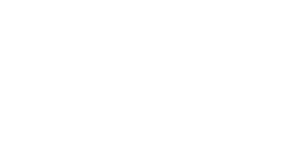

interactive(children=(IntSlider(value=0, description='i_frame', max=5), Output()), _dom_classes=('widget-inter…

<IPython.core.display.Javascript object>


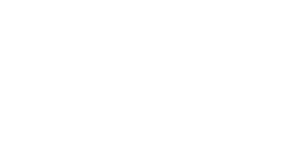

interactive(children=(IntSlider(value=0, description='i_frame', max=5), Output()), _dom_classes=('widget-inter…

<IPython.core.display.Javascript object>


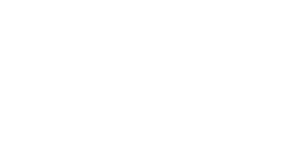

interactive(children=(IntSlider(value=0, description='i_frame', max=24881), Output()), _dom_classes=('widget-i…

In [11]:
%matplotlib notebook

visualization.display_toggle_image_stack(data.FOV_images)

visualization.display_toggle_image_stack([sf.max(0).reshape(data.FOV_height, data.FOV_width).toarray() for sf in data.spatialFootprints], clim=[0,0.1])

visualization.display_toggle_image_stack(np.concatenate(data.ROI_images, axis=0))

# Alignment

In [12]:
use_CLAHE = True
idx_session_template = 0.5
idx_st = int(idx_session_template * data.n_sessions) if type(idx_session_template) is float else idx_session_template

FOV_images = [alignment.clahe(im, grid_size=10, clipLimit=0, normalize=True) for im in data.FOV_images] if use_CLAHE else data.FOV_images

pcr = alignment.PhaseCorrelation_registration()

pcr.set_spectral_mask(
    freq_highPass=0.01,
    freq_lowPass=0.3,
    im_shape=(data.FOV_height, data.FOV_width)
)

pcr.register(
    template=FOV_images[idx_st],
    ims_moving=FOV_images,
    template_method='image',
);

aligner = alignment.Alinger(
    method='createOptFlow_DeepFlow',
    kwargs_method=None
)

aligner.register_ROIs(
    template=pcr.ims_registered[idx_st],
    FOVs=pcr.ims_registered,
    ROIs=data.spatialFootprints,
    template_method='image',
    shifts=pcr.shifts[:],
    return_sparse=True,
    normalize=True,
);

Finding optical flow fields between FOVs using image template...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.44it/s]


Registering ROIs...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:23<00:00, 13.92s/it]


<IPython.core.display.Javascript object>


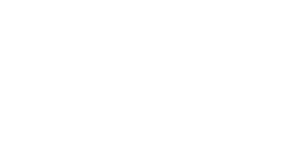

interactive(children=(IntSlider(value=0, description='i_frame', max=5), Output()), _dom_classes=('widget-inter…

<IPython.core.display.Javascript object>


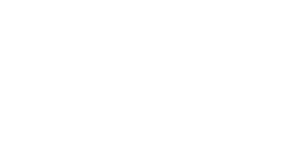

interactive(children=(IntSlider(value=0, description='i_frame', max=5), Output()), _dom_classes=('widget-inter…

<IPython.core.display.Javascript object>


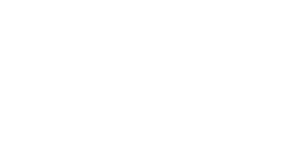

interactive(children=(IntSlider(value=0, description='i_frame', max=5), Output()), _dom_classes=('widget-inter…

<IPython.core.display.Javascript object>


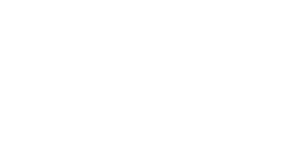

interactive(children=(IntSlider(value=0, description='i_frame', max=5), Output()), _dom_classes=('widget-inter…

In [13]:
%matplotlib notebook

visualization.display_toggle_image_stack(pcr.ims_registered[:])

visualization.display_toggle_image_stack(aligner.FOVs_aligned)
visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection(), clim=[0,0.03])
visualization.display_toggle_2channel_image_stack(aligner.flows)

In [14]:
toc['alignment'] = time.time() - tic

## Blur ROIs (optional)

In [15]:
blurrer = blurring.ROI_Blurrer(
    frame_shape=(data.FOV_height, data.FOV_width),
    kernel_halfWidth=2,
    plot_kernel=False,
)

blurrer.blur_ROIs(
    spatialFootprints=aligner.ROIs_aligned[:],
)

Preparing the Toeplitz convolution matrix
Performing convolution for blurring


<IPython.core.display.Javascript object>


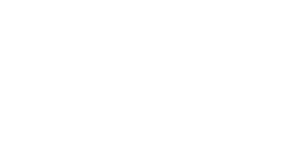

interactive(children=(IntSlider(value=0, description='i_frame', max=5), Output()), _dom_classes=('widget-inter…

In [16]:
%matplotlib notebook
visualization.display_toggle_image_stack(blurrer.get_ROIsBlurred_maxIntensityProjection())

In [17]:
toc['blur'] = time.time() - tic

In [18]:
toc['blur']

111.133798122406

## Neural network embedding distances

In [19]:
data.um_per_pixel = 1.32

In [20]:

hash_dict_true = {
    'params': ('params.json', '68cf1bd47130f9b6d4f9913f86f0ccaa'),
    'model': ('model.py', '61c85529b7aa33e0dfadb31ee253a7e1'),
    'state_dict': ('ConvNext_tiny__1_0_best__simCLR.pth', '3287e001ff28d07ada2ae70aa7d0a4da'),
}

roinet = ROInet.ROInet_embedder(
    device='cuda:0',
    dir_networkFiles='/home/rich/Downloads/ROInet',
    
#     download_from_gDrive='force_download',
#     download_from_gDrive='force_local',
    download_from_gDrive='check_local_first',
    gDriveID='1D2Qa-YUNX176Q-wgboGflW0K6un7KYeN',
    hash_dict_networkFiles=hash_dict_true,
#     hash_dict_networkFiles=None,
    forward_pass_version='latent',
    verbose=True,
)

    
roinet.generate_dataloader(
    ROI_images=data.ROI_images,
    um_per_pixel=data.um_per_pixel,
    pref_plot=False,
    batchSize_dataloader=1, #8
    pinMemory_dataloader=False, #True
    numWorkers_dataloader=0, #mp.cpu_count(),
    persistentWorkers_dataloader=False, #True,
    prefetchFactor_dataloader=2,    
);

Successful hash comparison. Found matching files: {'params': 'C:/home/rich/Downloads/ROInet/params.json', 'model': 'C:/home/rich/Downloads/ROInet/model.py', 'state_dict': 'C:/home/rich/Downloads/ROInet/ConvNext_tiny__1_0_best__simCLR.pth'}
Imported model from /home/rich/Downloads/ROInet/model.py
Loaded params_model from C:/home/rich/Downloads/ROInet/params.json


C:\Users\andrew\anaconda3\envs\ROICaT\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\andrew\anaconda3\envs\ROICaT\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from C:/home/rich/Downloads/ROInet/ConvNext_tiny__1_0_best__simCLR.pth
Loaded network onto device cuda:0
Starting: resizing ROIs


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.48it/s]


Completed: resizing ROIs
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader


<IPython.core.display.Javascript object>


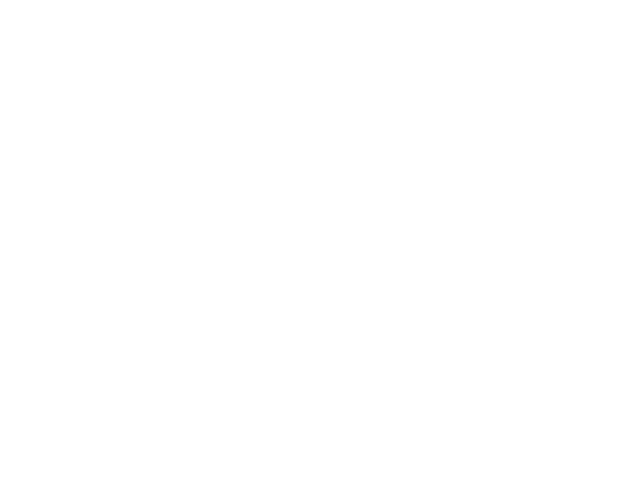

interactive(children=(IntSlider(value=0, description='i_frame', max=24881), Output()), _dom_classes=('widget-i…

In [21]:
%matplotlib notebook
visualization.display_toggle_image_stack(roinet.ROI_images_rs)

In [22]:
roinet.generate_latents();


starting: running data through network


  0%|                                                                                        | 0/24882 [00:00<?, ?it/s]C:\Users\andrew\anaconda3\envs\ROICaT\lib\site-packages\torch\nn\modules\module.py:1130: UserWarning: operator () profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\jit\codegen\cuda\graph_fuser.cpp:108.)
  return forward_call(*input, **kwargs)
100%|███████████████████████████████████████████████████████████████████████████| 24882/24882 [01:32<00:00, 268.06it/s]

completed: running data through network


In [23]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

In [24]:
toc['NN'] = time.time() - tic

## Scattering wavelet embedding distances

In [25]:
swt = scatteringWaveletTransformer.SWT(
    kwargs_Scattering2D={'J': 2, 'L': 2}, 
    image_shape=data.ROI_images[0].shape[1:3], 
    device='cuda:0'
)

swt.transform(
    ROI_images=np.concatenate(data.ROI_images, axis=0),
    batch_size=100,
);

SWT initialized
Starting: SWT transform on ROIs


  0%|                                                                                       | 0/248.82 [00:00<?, ?it/s]C:\Users\andrew\anaconda3\envs\ROICaT\lib\site-packages\tqdm\std.py:533: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████████████████████████████████████████████████| 249/248.82 [00:00<00:00, 418.22it/s]

Completed: SWT transform on ROIs


In [26]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()


In [27]:
toc['SWT'] = time.time() - tic

## Compute similarities

<IPython.core.display.Javascript object>


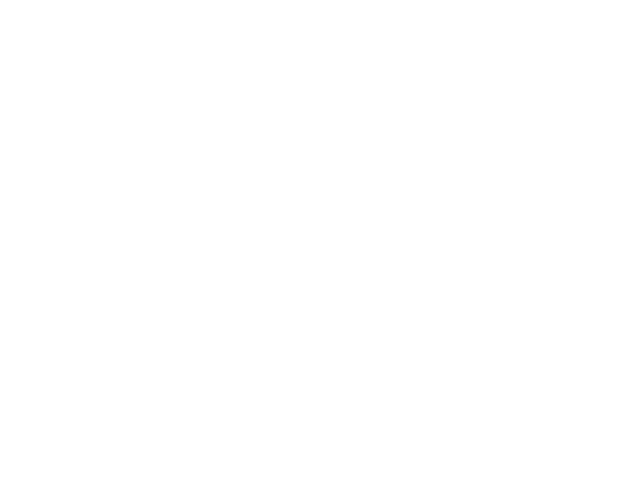

Computing pairwise similarity between ROIs...


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.75it/s]


Joining blocks into full similarity matrices...
Joining s_sf...


16it [00:00, 842.10it/s]


Joining s_NN...


16it [00:00, 200.00it/s]


Joining s_SWT...


16it [00:00, 195.04it/s]


Joining s_sesh...


16it [00:00, 199.94it/s]


In [28]:
sim = similarity_graph.ROI_graph(
    n_workers=-1,
    frame_height=data.FOV_height,
    frame_width=data.FOV_width,
#     block_height=data.FOV_height,
#     block_width=data.FOV_width,
    block_height=128,
    block_width=128,
    algorithm_nearestNeigbors_spatialFootprints='brute',
    verbose=True,
)

sim.visualize_blocks()

s_sf, s_NN, s_SWT, s_sesh = sim.compute_similarity_blockwise(
    spatialFootprints=blurrer.ROIs_blurred,
#     spatialFootprints=aligner.ROIs_aligned,
    features_NN=roinet.latents,
    features_SWT=swt.latents,
    ROI_session_bool=data.sessionID_concat,
    spatialFootprint_maskPower=0.8,
);

In [29]:
sim.make_normalized_similarities(
    centers_of_mass=data.centroids,
    features_NN=roinet.latents,
    features_SWT=swt.latents,
#     features_SWT=None,
    k_max=4000,
    k_min=100,
    algo_NN='kd_tree',
    device='cuda:0'
)

toc['sim'] = time.time() - tic

Finding k-range of center of mass distance neighbors for each ROI...
Normalizing Neural Network similarity scores...


100%|█████████████████████████████████████████████████████████████████████████| 24882/24882 [00:02<00:00, 11770.12it/s]


Normalizing SWT similarity scores...


100%|██████████████████████████████████████████████████████████████████████████| 24882/24882 [00:04<00:00, 5680.63it/s]


# Clustering

Finding mixing parameters using automated hyperparameter tuning...
Best value found: 0.08375603705644608 with parameters {'power_SF': 1.9374187767276352, 'power_NN': 0.3620756741596858, 'power_SWT': 0.2773606478591897, 'p_norm': -4.083449897774924, 'sig_SF_kwargs': None, 'sig_NN_kwargs': {'mu': 0.13054125255777152, 'b': 0.5930322600282365}, 'sig_SWT_kwargs': {'mu': 0.26802898800981834, 'b': 0.7170403392133403}}


<IPython.core.display.Javascript object>


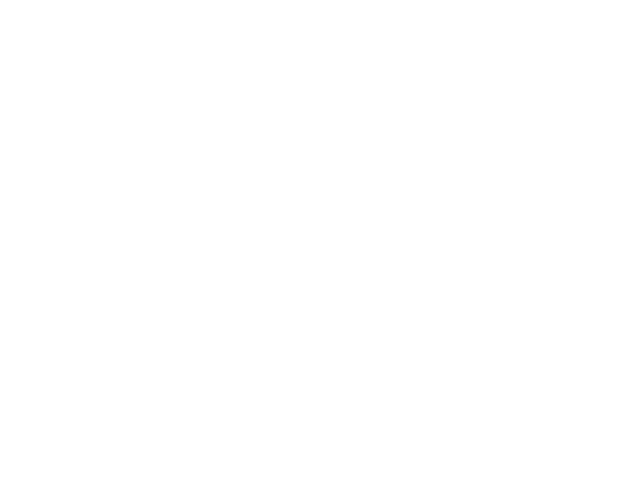

<IPython.core.display.Javascript object>


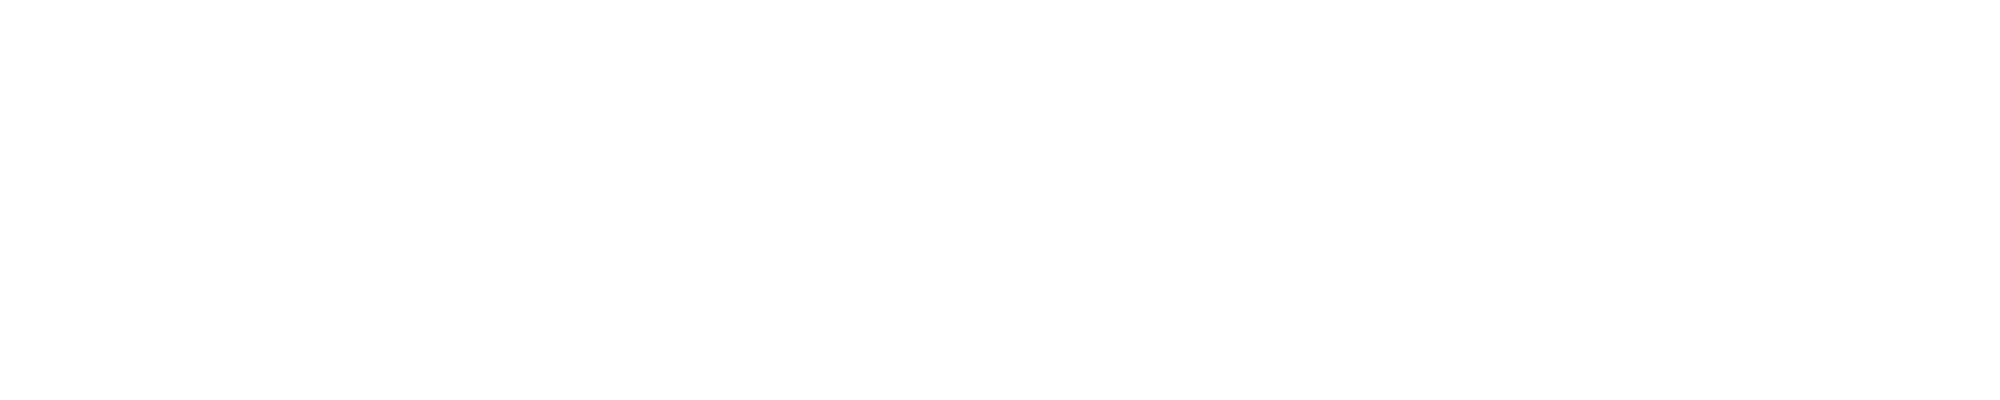

C:\Users\andrew\anaconda3\envs\ROICaT\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [30]:
clusterer = clustering.Clusterer(
    s_sf=sim.s_sf,
    s_NN_z=sim.s_NN_z,
    s_SWT_z=sim.s_SWT_z,
    s_sesh=sim.s_sesh,
)

kwargs_makeConjunctiveDistanceMatrix_best = clusterer.find_optimal_parameters_for_pruning(
    n_bins=50,
    find_parameters_automatically=True,
    kwargs_findParameters={
        'n_patience': 100,
        'tol_frac': 0.05,
        'max_trials': 350,
        'max_duration': 60*10,
        'verbose': False,
    },
    bounds_findParameters={
        'power_SF': (0.3, 2),
        'power_NN': (0.2, 2),
        'power_SWT': (0.1, 1),
        'p_norm': (-5, 5),
        'sig_NN_kwargs_mu': (0, 0.5),
        'sig_NN_kwargs_b': (0.05, 2),
        'sig_SWT_kwargs_mu': (0, 0.5),
        'sig_SWT_kwargs_b': (0.05, 2),
    },
    n_jobs_findParameters=-1,    
#     fallback_d_cutoff=0.5,
#     plot_pref=True,
)

toc['separate_diffSame'] = time.time() - tic

clusterer.plot_distSame()

clusterer.plot_similarity_relationships(
    plots_to_show=[1,2,3], 
    max_samples=100000, 
    kwargs_scatter={'s':1, 'alpha':0.2},
    kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
#     kwargs_makeConjunctiveDistanceMatrix={
#         'power_SF': 1.0,
#         'power_NN': 1.0,
#         'power_SWT': 0.1,
#         'p_norm': -4.0,
#         'sig_SF_kwargs': {'mu':0.5, 'b':4},
# #         'sig_SF_kwargs': None,
#         'sig_NN_kwargs': {'mu':0.5, 'b':1.5},
#         'sig_SWT_kwargs': {'mu':0.5, 'b':0.5},
#     },
);

clusterer.make_pruned_similarity_graphs(
    kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best
)

In [31]:
if data.n_sessions >= 10:
    labels = clusterer.fit(
        session_bool=data.sessionID_concat,
        min_cluster_size=2,
        cluster_selection_method='leaf',
        d_clusterMerge=None,
        alpha=0.999,
        n_iter_violationCorrection=3,
        d_conj=None,
        kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
    #     kwargs_makeConjunctiveDistanceMatrix={
    #         'power_SF': 1.0,
    #         'power_NN': 1.0,
    #         'power_SWT': 0.1,
    #         'p_norm': -2,
    #         'sig_SF_kwargs': None,
    #         'sig_NN_kwargs':  {'mu':0, 'b':0.2},
    #         'sig_SWT_kwargs': {'mu':0, 'b':0.2},
    #     },
        split_intraSession_clusters=True,
        discard_failed_pruning=True,
        d_step=0.01,
    )

else:
    labels = clusterer.fit_sequentialHungarian(
        session_bool=data.sessionID_concat,
        thresh_cost=0.6,
        d_conj=None,
        kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
    #     kwargs_makeConjunctiveDistanceMatrix={
    #     'power_SF': 1.0,
    #     'power_NN': 1.0,
    #     'power_SWT': 0.1,
    #     'p_norm': -2,
    #     'sig_SF_kwargs': None,
    #     'sig_NN_kwargs':  {'mu':0, 'b':0.2},
    #     'sig_SWT_kwargs': {'mu':0, 'b':0.2},
    #     },
    )

labels_bySession = [labels[idx] for idx in data.sessionID_concat.T]

Clustering with CaImAn's sequential Hungarian algorithm method...


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.52it/s]


In [32]:
## results_clustering
print(f'Number of clusters: {len(np.unique(labels))}')
print(f'Number of discarded ROIs: {(labels==-1).sum()}')

Number of clusters: 6263
Number of discarded ROIs: 3642


In [33]:
toc['clustering'] = time.time() - tic

In [34]:
toc['clustering']

264.2135200500488

# Visualize results

In [35]:
FOV_clusters = visualization.compute_colored_FOV(
    spatialFootprints=[r.power(0.7) for r in aligner.ROIs_aligned],
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    boolSessionID=data.sessionID_concat,
    labels=labels,
    confidence=None,
)

<IPython.core.display.Javascript object>


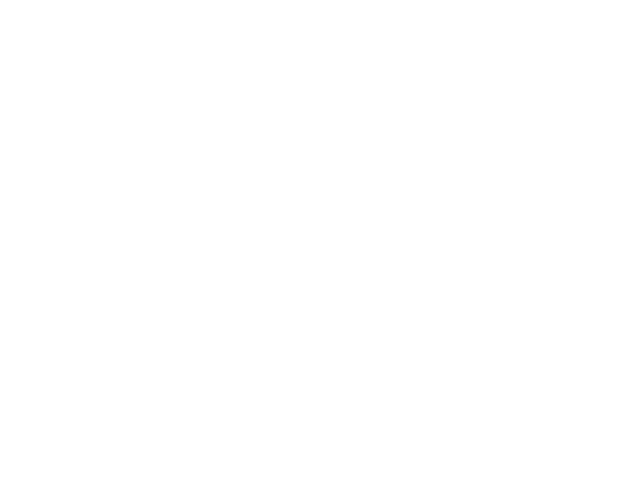

interactive(children=(IntSlider(value=0, description='i_frame', max=5), Output()), _dom_classes=('widget-inter…

In [36]:
%matplotlib notebook
visualization.display_toggle_image_stack(
    FOV_clusters, 
#     interpolation='none', 
#     filternorm=False, 
#     resample=False
)

In [37]:
# visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection())

<IPython.core.display.Javascript object>


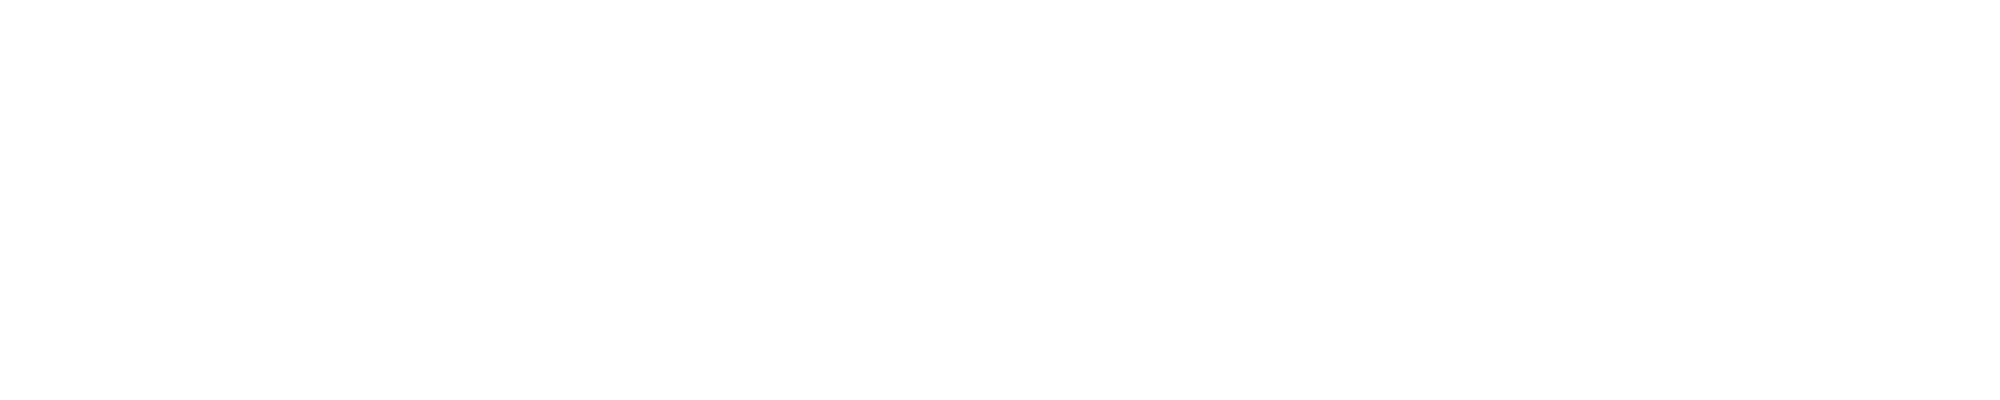

In [38]:
clusterer.plot_similarity_relationships(
    plots_to_show=[1,2,3], 
    max_samples=100000, 
    kwargs_scatter={'s':1, 'alpha':0.2},
    kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
#     kwargs_makeConjunctiveDistanceMatrix={
#         'power_SF': 1.0,
#         'power_NN': 1.0,
#         'power_SWT': 0.1,
#         'p_norm': -4.0,
#         'sig_SF_kwargs': {'mu':0.5, 'b':4},
# #         'sig_SF_kwargs': None,
#         'sig_NN_kwargs': {'mu':0.5, 'b':1.5},
#         'sig_SWT_kwargs': {'mu':0.5, 'b':0.5},
#     },
);


C:\Users\andrew\AppData\Local\Temp\ipykernel_19972\2710547728.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(40,1))


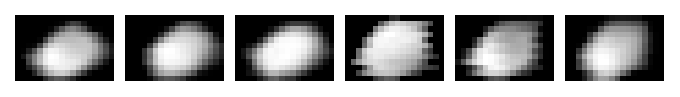

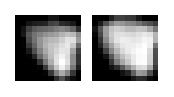

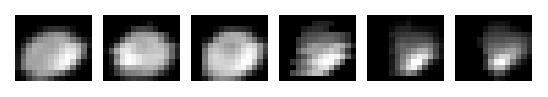

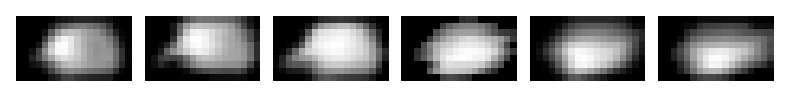

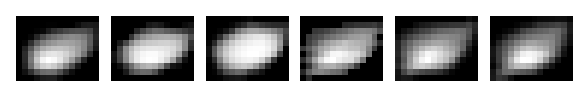

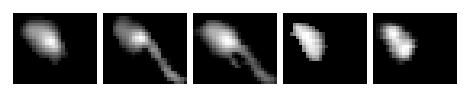

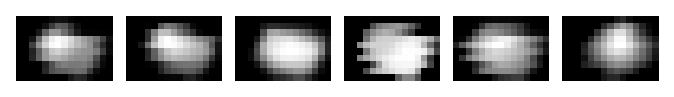

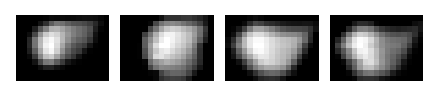

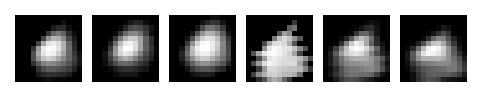

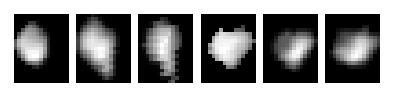

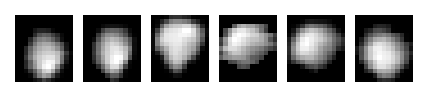

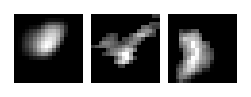

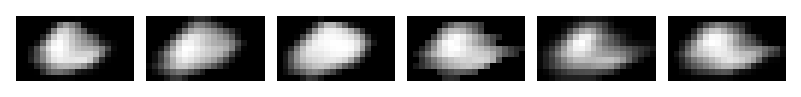

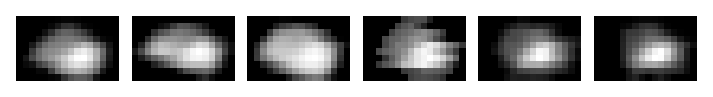

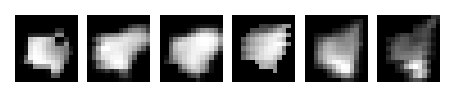

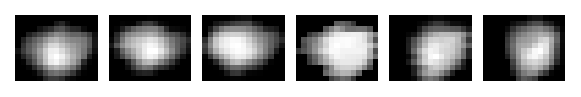

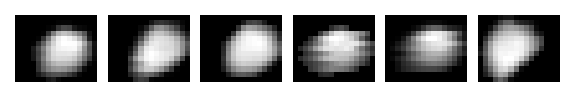

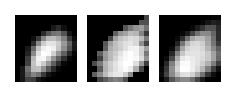

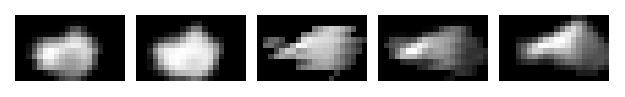

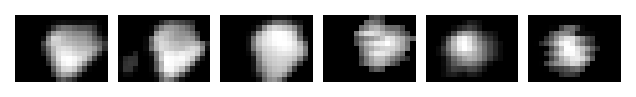

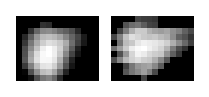

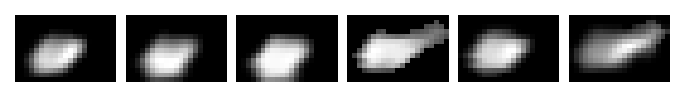

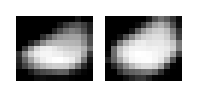

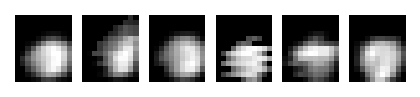

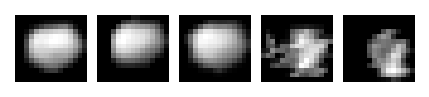

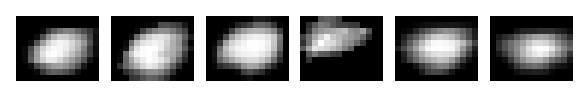

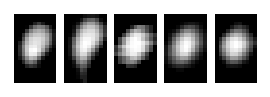

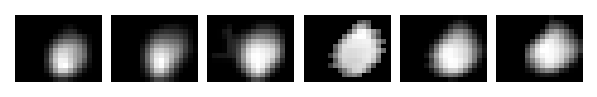

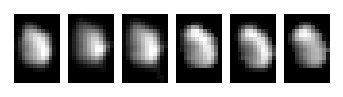

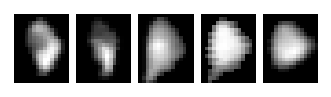

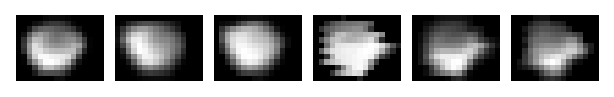

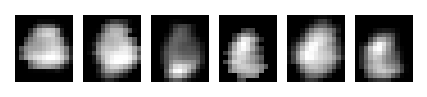

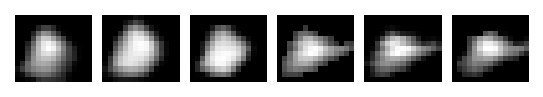

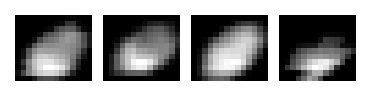

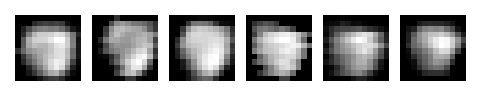

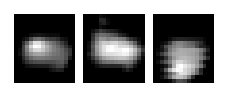

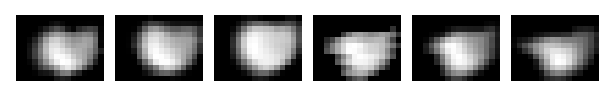

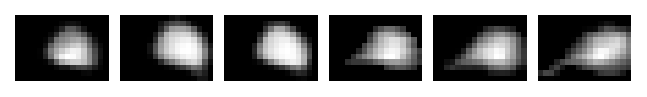

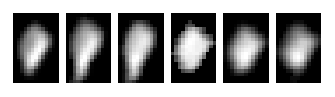

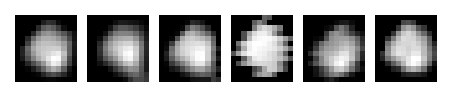

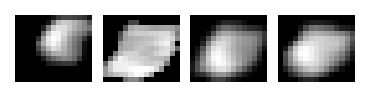

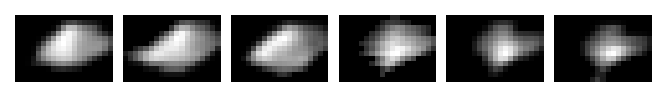

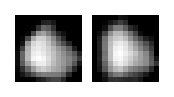

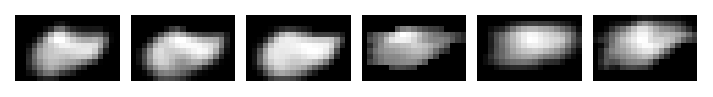

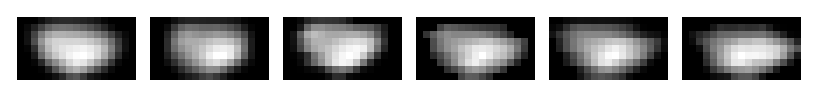

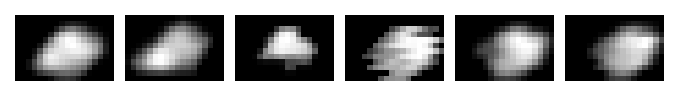

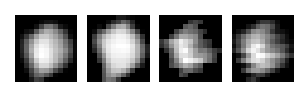

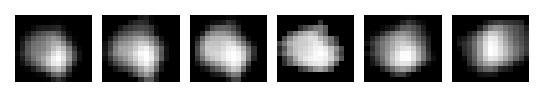

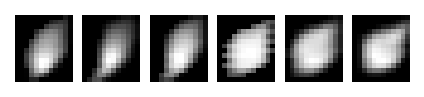

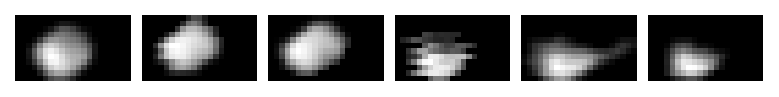

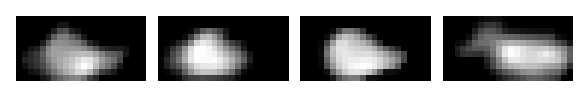

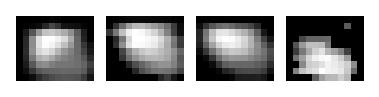

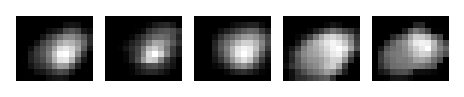

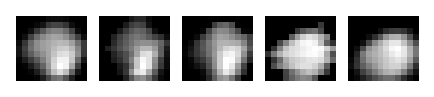

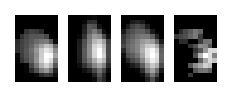

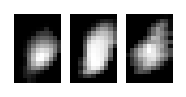

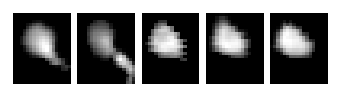

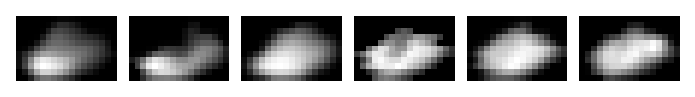

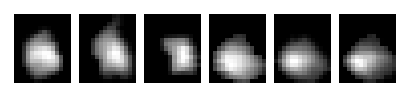

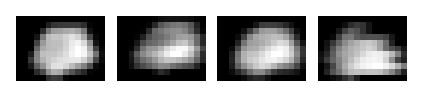

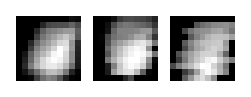

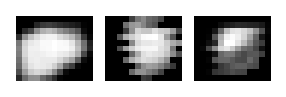

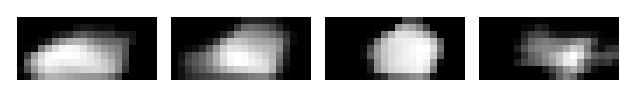

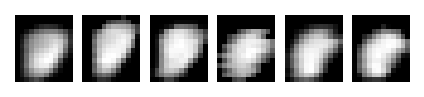

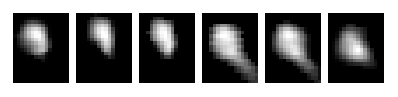

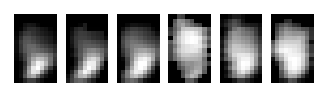

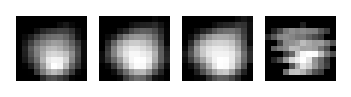

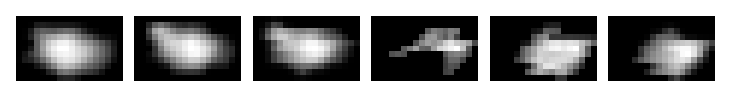

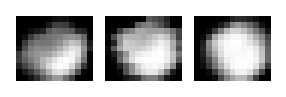

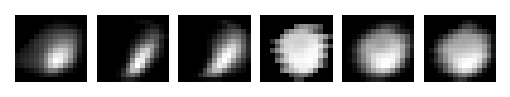

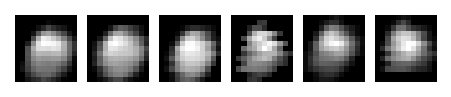

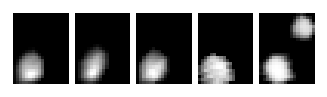

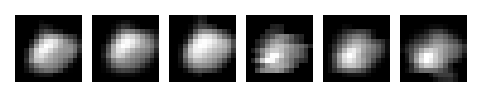

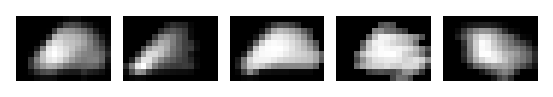

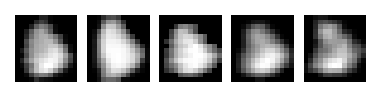

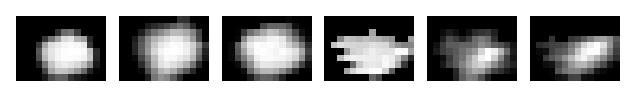

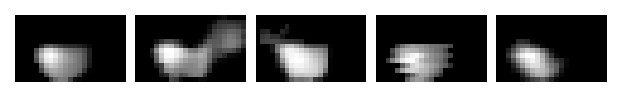

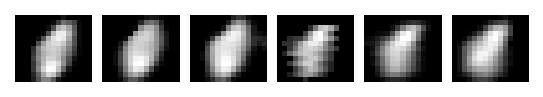

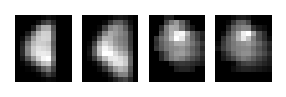

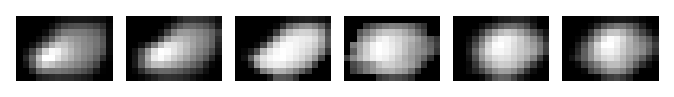

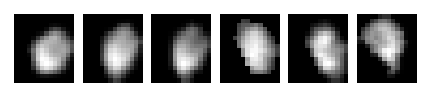

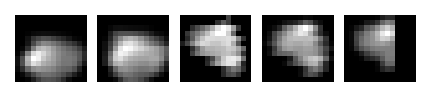

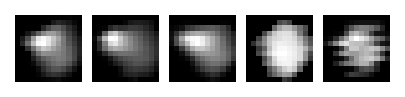

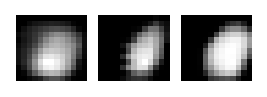

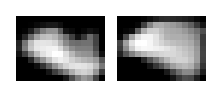

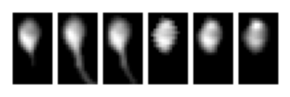

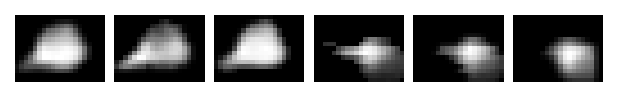

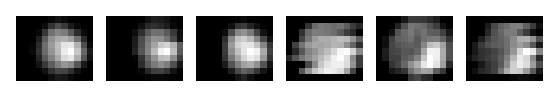

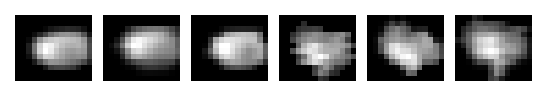

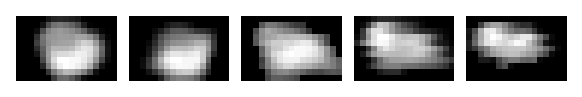

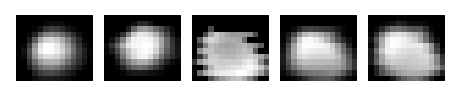

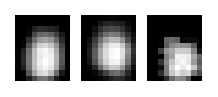

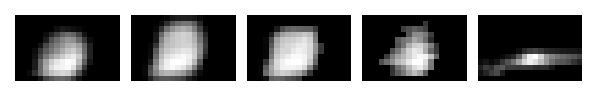

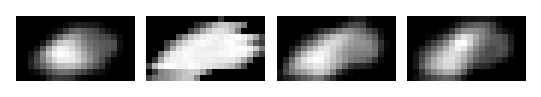

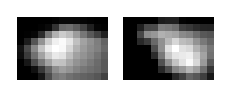

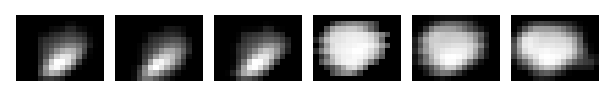

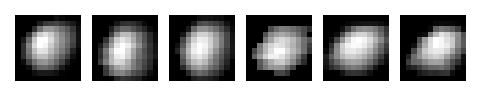

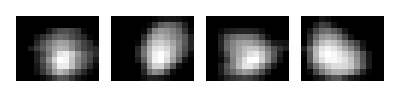

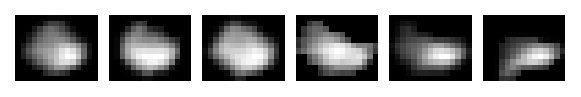

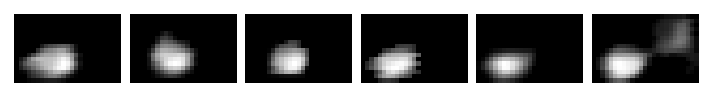

In [39]:
import scipy.sparse

ucids = labels.copy()
# ucids = ucids[ucids==975]
ucids_unique = np.unique(ucids[ucids>-1])

# ROI_ims = np.concatenate(data.ROI_images, axis=0)
ROI_ims_sparse = scipy.sparse.vstack(aligner.ROIs_aligned)
ROI_ims_sparse = ROI_ims_sparse.multiply( ROI_ims_sparse.max(1).power(-1) ).tocsr()


ucid_sfCat = []
for ucid in ucids_unique:
    idx = np.where(ucids == ucid)[0]
    ucid_sfCat.append( np.concatenate(list(visualization.crop_cluster_ims(ROI_ims_sparse[idx].toarray().reshape(len(idx), data.FOV_height, data.FOV_width))), axis=1) )
#     ucid_sfCat.append( np.concatenate(list(ROI_ims_sparse[idx].toarray().reshape(len(idx), data.FOV_height, data.FOV_width)), axis=1) )
# data.ROI_images[i_sesh][idx] for 


%matplotlib inline

for sf in ucid_sfCat[:100]:
    plt.figure(figsize=(40,1))
    plt.imshow(sf, cmap='gray')
    plt.axis('off')

<IPython.core.display.Javascript object>


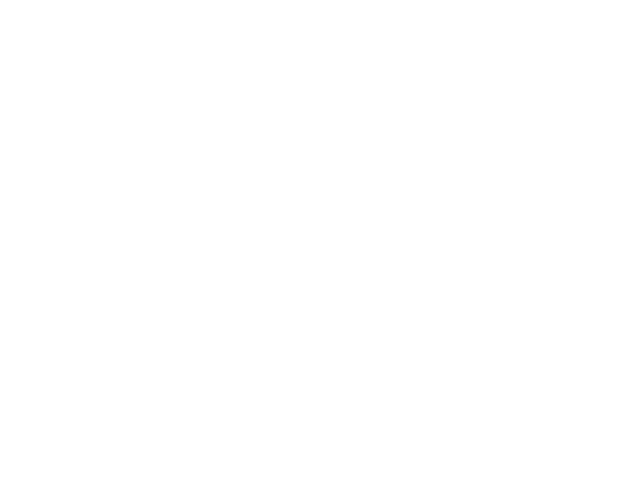

In [40]:
%matplotlib notebook

_, counts = np.unique(labels, return_counts=True)

plt.figure()
plt.hist(counts, 30, range=(0, data.n_sessions+1));


In [41]:
toc['visualize'] = time.time() - tic

# Save results

In [42]:
# Andrew's Save Block:
dir_save = Path(os.path.join('C:','\\Users','andrew','Documents','localData',useMouse,'roicat')).resolve()
path_save = dir_save / (usePlane + '.ROICaT.results' + '.pkl')
mat_save = dir_save / (usePlane + '.ROICaT.results' + '.mat')

META = {
    "useMouse": useMouse, 
    "useDates": useDates,
    "useSessions": useSessions,
    "usePlane": usePlane
}

ROIs = {
    "ROIs_aligned": aligner.ROIs_aligned,
    "ROIs_raw": data.spatialFootprints,
    "frame_height": data.FOV_height,
    "frame_width": data.FOV_width,
    "idx_roi_session": np.where(data.sessionID_concat)[1]
}

ALIGN = {
    "shifts": pcr.shifts,
    "flows": aligner.flows
}

results = {
    "UCIDs": labels,
    "UCIDs_bySession": labels_bySession,
    "ALIGN": ALIGN,
    "ROIs": ROIs,
    "META": META,
}

helpers.pickle_save(
    obj=results,
    path_save=path_save,
    mkdir=True,
)

scipy.io.savemat(mat_save, mdict=results)

C:\Users\andrew\anaconda3\envs\ROICaT\lib\site-packages\scipy\io\matlab\_mio5.py:493: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  narr = np.asanyarray(source)


In [43]:
# Original Save Block:
# dir_save = Path('/home/rich/Desktop/').resolve()
# name_save = dir_allOuterFolders.name
# path_save = dir_save / (name_save + '.ROICaT.results' + '.pkl')

# ROIs = {
#     "ROIs_aligned": aligner.ROIs_aligned,
#     "ROIs_raw": data.spatialFootprints,
#     "frame_height": data.FOV_height,
#     "frame_width": data.FOV_width,
#     "idx_roi_session": np.where(data.sessionID_concat)[1]
# }

# results = {
#     "UCIDs": labels,
#     "UCIDs_bySession": labels_bySession,
#     "ROIs": ROIs,
# }

# helpers.pickle_save(
#     obj=results,
#     filename=path_save,
#     mkdir=True,
# )

In [44]:
toc['saving'] = time.time() - tic

In [45]:
toc

{'start': 0.0,
 'import_paths': 1.3452503681182861,
 'import_data': 1.406250238418579,
 'alignment': 110.59679889678955,
 'blur': 111.133798122406,
 'NN': 206.99794840812683,
 'SWT': 208.12018585205078,
 'sim': 252.07254076004028,
 'separate_diffSame': 256.71855545043945,
 'clustering': 264.2135200500488,
 'visualize': 284.57363533973694,
 'saving': 284.8087091445923}